In [1]:
!pip -q install /kaggle/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl

In [2]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone, BaseEstimator, RegressorMixin
from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.callbacks import Callback

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
import random
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

SEED = 42
n_splits = 5

# Modelling part starts

In [3]:
def initialize_random_seed(seed: int):
    """Set the random seed for reproducibility across multiple libraries."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


initialize_random_seed(2024)


def extract_file_statistics(file_name: str, directory: str):
    """Read a parquet file, drop the 'step' column, and return statistics and an identifier."""
    file_path = os.path.join(directory, file_name, 'part-0.parquet')
    data_frame = pd.read_parquet(file_path)
    data_frame.drop(columns='step', inplace=True)
    file_stats = data_frame.describe().values.reshape(-1)
    file_id = file_name.split('=')[1]
    return file_stats, file_id


def load_time_series_data(directory: str) -> pd.DataFrame:
    """Load and process time series data from a directory."""
    file_names = os.listdir(directory)

    with ThreadPoolExecutor() as executor:
        results = list(
            tqdm(
                executor.map(lambda f: extract_file_statistics(f, directory), file_names),
                total=len(file_names),
                desc="Processing time series files"
            )
        )

    statistics, identifiers = zip(*results)
    stats_df = pd.DataFrame(statistics, columns=[f"stat_{i}" for i in range(len(statistics[0]))])
    stats_df['id'] = identifiers
    return stats_df


class TimeSeriesAutoEncoder(nn.Module):
    """An autoencoder model for dimensionality reduction of time series data."""

    def __init__(self, input_dim: int, encoding_dim: int):
        super(TimeSeriesAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 3),
            nn.ReLU(),
            nn.Linear(encoding_dim * 3, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim * 2),
            nn.ReLU(),
            nn.Linear(input_dim * 2, input_dim * 3),
            nn.ReLU(),
            nn.Linear(input_dim * 3, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def apply_autoencoder(data_frame: pd.DataFrame, encoding_dim: int = 50, epochs: int = 50, batch_size: int = 32) -> pd.DataFrame:
    """Train an autoencoder on the data and return the encoded features."""
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_frame)
    data_tensor = torch.FloatTensor(scaled_data)

    input_dim = data_tensor.shape[1]
    autoencoder_model = TimeSeriesAutoEncoder(input_dim, encoding_dim)

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(autoencoder_model.parameters())

    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i:i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder_model(batch)
            loss = loss_function(reconstructed, batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    with torch.no_grad():
        encoded_features = autoencoder_model.encoder(data_tensor).numpy()

    return pd.DataFrame(encoded_features, columns=[f"Enc_{i + 1}" for i in range(encoded_features.shape[1])])


def engineer_features(data_frame: pd.DataFrame) -> pd.DataFrame:
    """Perform feature engineering on the data frame."""
    # Drop season-related columns
    season_columns = [col for col in data_frame.columns if 'Season' in col]
    data_frame = data_frame.drop(columns=season_columns)

    # Create new features based on existing columns
    data_frame['BMI_Age'] = data_frame['Physical-BMI'] * data_frame['Basic_Demos-Age']
    data_frame['Internet_Hours_Age'] = data_frame['PreInt_EduHx-computerinternet_hoursday'] * data_frame['Basic_Demos-Age']
    data_frame['BMI_Internet_Hours'] = data_frame['Physical-BMI'] * data_frame['PreInt_EduHx-computerinternet_hoursday']
    data_frame['BFP_BMI'] = data_frame['BIA-BIA_Fat'] / data_frame['BIA-BIA_BMI']
    data_frame['FFMI_BFP'] = data_frame['BIA-BIA_FFMI'] / data_frame['BIA-BIA_Fat']
    data_frame['FMI_BFP'] = data_frame['BIA-BIA_FMI'] / data_frame['BIA-BIA_Fat']
    data_frame['LST_TBW'] = data_frame['BIA-BIA_LST'] / data_frame['BIA-BIA_TBW']
    data_frame['BFP_BMR'] = data_frame['BIA-BIA_Fat'] * data_frame['BIA-BIA_BMR']
    data_frame['BFP_DEE'] = data_frame['BIA-BIA_Fat'] * data_frame['BIA-BIA_DEE']
    data_frame['BMR_Weight'] = data_frame['BIA-BIA_BMR'] / data_frame['Physical-Weight']
    data_frame['DEE_Weight'] = data_frame['BIA-BIA_DEE'] / data_frame['Physical-Weight']
    data_frame['SMM_Height'] = data_frame['BIA-BIA_SMM'] / data_frame['Physical-Height']
    data_frame['Muscle_to_Fat'] = data_frame['BIA-BIA_SMM'] / data_frame['BIA-BIA_FMI']
    data_frame['Hydration_Status'] = data_frame['BIA-BIA_TBW'] / data_frame['Physical-Weight']
    data_frame['ICW_TBW'] = data_frame['BIA-BIA_ICW'] / data_frame['BIA-BIA_TBW']
    data_frame['BMI_PHR'] = data_frame['Physical-BMI'] * data_frame['Physical-HeartRate']

    return data_frame


# Load datasets
train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample_submission = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

# Process time series data
train_time_series = load_time_series_data("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_time_series = load_time_series_data("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

# Perform autoencoder encoding on time series data
train_encoded_features = apply_autoencoder(train_time_series.drop(columns=['id']), encoding_dim=60, epochs=100, batch_size=32)
test_encoded_features = apply_autoencoder(test_time_series.drop(columns=['id']), encoding_dim=60, epochs=100, batch_size=32)

# Add IDs back to the encoded features
time_series_cols = train_encoded_features.columns.tolist()
train_encoded_features['id'] = train_time_series['id']
test_encoded_features['id'] = test_time_series['id']

# Merge encoded features with train and test datasets
train_df = pd.merge(train_df, train_encoded_features, on='id', how='left')
test_df = pd.merge(test_df, test_encoded_features, on='id', how='left')


Processing time series files: 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


Epoch [10/100], Loss: 1.6710
Epoch [20/100], Loss: 1.5469
Epoch [30/100], Loss: 1.5154
Epoch [40/100], Loss: 1.4932
Epoch [50/100], Loss: 1.4964
Epoch [60/100], Loss: 1.4920
Epoch [70/100], Loss: 1.4309
Epoch [80/100], Loss: 1.4185
Epoch [90/100], Loss: 1.3667
Epoch [100/100], Loss: 1.3620
Epoch [10/100], Loss: 1.0070
Epoch [20/100], Loss: 0.5783
Epoch [30/100], Loss: 0.4271
Epoch [40/100], Loss: 0.4271
Epoch [50/100], Loss: 0.4271
Epoch [60/100], Loss: 0.4271
Epoch [70/100], Loss: 0.4271
Epoch [80/100], Loss: 0.4271
Epoch [90/100], Loss: 0.4271
Epoch [100/100], Loss: 0.4271


# **Insights into the Data - Exploring the Data** 

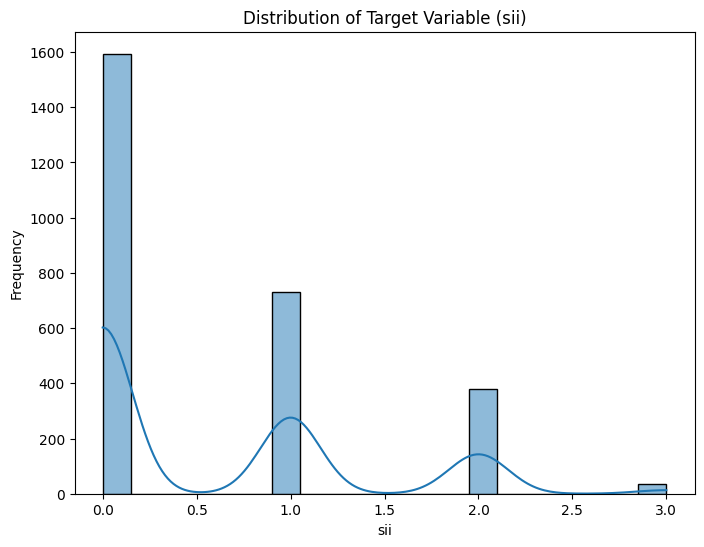

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of the target variable in the training data
plt.figure(figsize=(8, 6))
sns.histplot(train_df['sii'], kde=True, bins=20)
plt.title('Distribution of Target Variable (sii)')
plt.xlabel('sii')
plt.ylabel('Frequency')
plt.show()


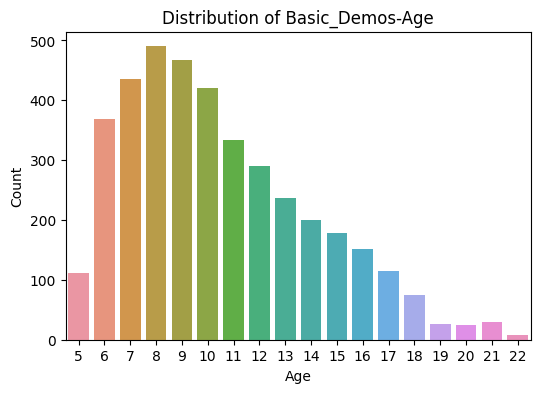

In [5]:
# Plot the distribution of a categorical feature (e.g., 'Basic_Demos-Sex')
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='Basic_Demos-Age')
plt.title('Distribution of Basic_Demos-Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Insight: If categorical variables have many unique values or imbalanced distributions, models like CatBoost can handle them effectively without extensive preprocessing.

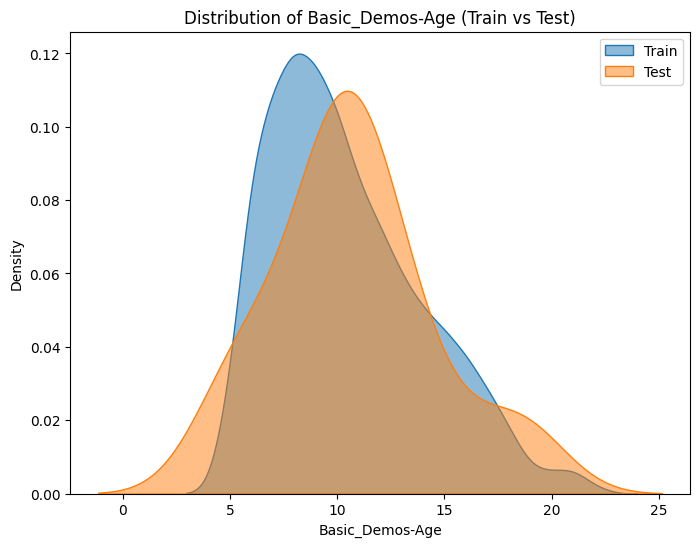

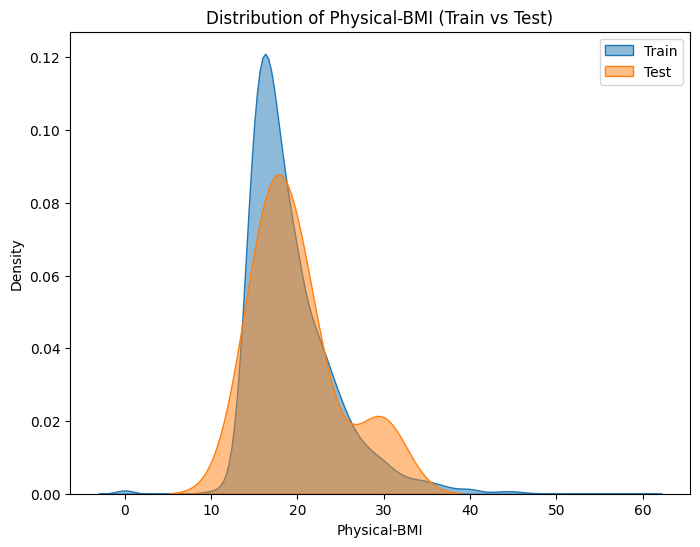

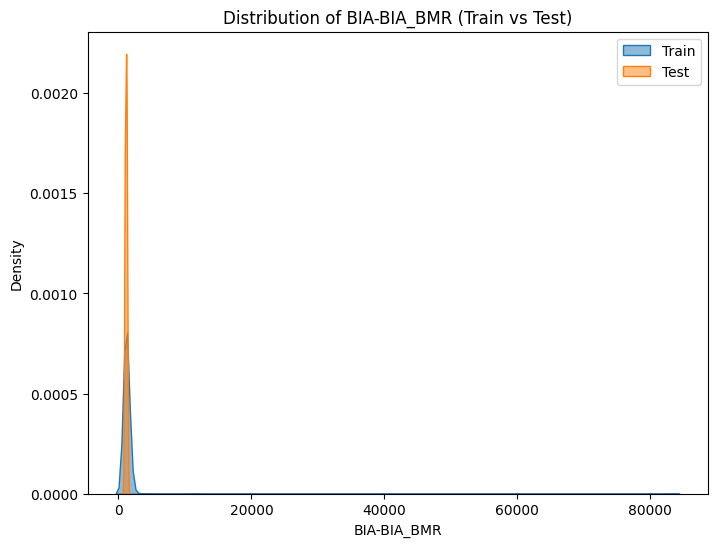

In [6]:
# Compare distributions of key features between train and test datasets
key_features = ['Basic_Demos-Age', 'Physical-BMI', 'BIA-BIA_BMR']  # Select key features
for feature in key_features:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(train_df[feature], label='Train', fill=True, alpha=0.5)
    sns.kdeplot(test_df[feature], label='Test', fill=True, alpha=0.5)
    plt.title(f'Distribution of {feature} (Train vs Test)')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [7]:
def impute_missing_values(data_frame: pd.DataFrame, numeric_columns: list, n_neighbors: int = 5) -> pd.DataFrame:
    """
    Impute missing values in numeric columns using KNN and merge with non-numeric columns.
    
    Args:
        data_frame (pd.DataFrame): Input data frame with missing values.
        numeric_columns (list): List of numeric column names to impute.
        n_neighbors (int): Number of neighbors to use for KNN imputation.
    
    Returns:
        pd.DataFrame: A data frame with imputed numeric columns and original non-numeric columns.
    """
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_values = imputer.fit_transform(data_frame[numeric_columns])
    imputed_df = pd.DataFrame(imputed_values, columns=numeric_columns, index=data_frame.index)
    
    # Merge non-numeric columns back into the imputed data frame
    for column in data_frame.columns:
        if column not in numeric_columns:
            imputed_df[column] = data_frame[column]
    
    return imputed_df

# Identify numeric columns for imputation
numeric_cols = train_df.select_dtypes(include=['int32', 'int64', 'float64', 'int64']).columns

# Impute missing values and ensure the 'sii' column is properly rounded and cast to integers
train_imputed_df = impute_missing_values(train_df, numeric_cols, n_neighbors=5)
if 'sii' in train_imputed_df.columns:
    train_imputed_df['sii'] = train_imputed_df['sii'].round().astype(int)

# Apply feature engineering to the training and test datasets
train_df = engineer_features(train_imputed_df)

# Drop rows with fewer than 10 non-NA values
train_df = train_df.dropna(thresh=10, axis=0)

# Apply feature engineering to the test dataset
test_df = engineer_features(test_df)


In [8]:
def select_and_clean_features(data_frame: pd.DataFrame, feature_columns: list, target_column: str = None) -> pd.DataFrame:
    """
    Select specified feature columns from the data frame and handle missing target values if provided.

    Args:
        data_frame (pd.DataFrame): The input data frame.
        feature_columns (list): List of columns to retain in the data frame.
        target_column (str, optional): Name of the target column to check for missing values.

    Returns:
        pd.DataFrame: Processed data frame with the selected features and non-missing target column values.
    """
    # Retain only the specified feature columns
    data_frame = data_frame[feature_columns]

    # Drop rows with missing target values if a target column is provided
    if target_column:
        data_frame = data_frame.dropna(subset=[target_column])

    return data_frame


# Drop the 'id' column (already merged into features)
train_df = train_df.drop(columns='id', errors='ignore')
test_df = test_df.drop(columns='id', errors='ignore')

# Define the feature columns
base_feature_columns = [
    'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
    'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone',
    'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone',
    'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone',
    'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
    'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR',
    'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI',
    'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM',
    'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T',
    'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age', 'Internet_Hours_Age',
    'BMI_Internet_Hours', 'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW',
    'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight', 'SMM_Height',
    'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR'
]

# Add time series features to the feature columns
all_feature_columns = base_feature_columns + time_series_cols

# Prepare training data (ensure 'sii' has no missing values)
train_df = select_and_clean_features(train_df, feature_columns=all_feature_columns + ['sii'], target_column='sii')

# Prepare test data
test_df = select_and_clean_features(test_df, feature_columns=all_feature_columns)


In [9]:
if np.any(np.isinf(train_df)):
    train_df = train_df.replace([np.inf, -np.inf], np.nan)

In [10]:
def calculate_quadratic_weighted_kappa(y_true, y_pred):
    """
    Calculate the quadratic weighted kappa score between true and predicted values.
    """
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')


def apply_threshold_rounding(predictions, thresholds):
    """
    Apply custom thresholds to round predictions into discrete classes.
    """
    return np.where(predictions < thresholds[0], 0,
                    np.where(predictions < thresholds[1], 1,
                             np.where(predictions < thresholds[2], 2, 3)))


def evaluate_kappa_with_thresholds(thresholds, y_true, predictions):
    """
    Evaluate predictions using a specific set of thresholds by calculating negative QWK score.
    """
    rounded_predictions = apply_threshold_rounding(predictions, thresholds)
    return -calculate_quadratic_weighted_kappa(y_true, rounded_predictions)


def TrainML(model_class, test_data):
    """
    Train a machine learning model using stratified K-fold cross-validation and optimize predictions.
    """
    X = train_df.drop(['sii'], axis=1)  # Consistent renaming of `train` to `train_df`
    y = train_df['sii']

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_kappa_scores = []
    validation_kappa_scores = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float)
    oof_rounded = np.zeros(len(y), dtype=int)
    test_predictions = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, validation_idx) in enumerate(
        tqdm(skf.split(X, y), desc="Training Folds", total=n_splits)
    ):
        X_train, X_validation = X.iloc[train_idx], X.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

        model_instance = clone(model_class)
        model_instance.fit(X_train, y_train)

        y_train_pred = model_instance.predict(X_train)
        y_validation_pred = model_instance.predict(X_validation)

        oof_non_rounded[validation_idx] = y_validation_pred
        y_validation_pred_rounded = y_validation_pred.round(0).astype(int)
        oof_rounded[validation_idx] = y_validation_pred_rounded

        train_kappa = calculate_quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        validation_kappa = calculate_quadratic_weighted_kappa(y_validation, y_validation_pred_rounded)

        train_kappa_scores.append(train_kappa)
        validation_kappa_scores.append(validation_kappa)
        
        test_predictions[:, fold] = model_instance.predict(test_data)
        
        print(f"Fold {fold + 1} - Train QWK: {train_kappa:.4f}, Validation QWK: {validation_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_kappa_scores):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(validation_kappa_scores):.4f}")

    # Optimize thresholds
    kappa_optimizer = minimize(
        evaluate_kappa_with_thresholds,
        x0=[0.5, 1.5, 2.5],
        args=(y, oof_non_rounded),
        method='Nelder-Mead'
    )
    assert kappa_optimizer.success, "Threshold optimization failed."

    optimized_predictions = apply_threshold_rounding(oof_non_rounded, kappa_optimizer.x)
    optimized_kappa = calculate_quadratic_weighted_kappa(y, optimized_predictions)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {optimized_kappa:.3f}{Style.RESET_ALL}")

    # Prepare test set predictions
    test_mean_predictions = test_predictions.mean(axis=1)
    final_test_predictions = apply_threshold_rounding(test_mean_predictions, kappa_optimizer.x)
    
    submission = pd.DataFrame({
        'id': sample_submission['id'],
        'sii': final_test_predictions
    })

    return submission


In [11]:
class TabNetRegressorWrapper(BaseEstimator, RegressorMixin):
    """
    A wrapper for the TabNet Regressor that includes preprocessing and checkpointing.
    """
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'

    def fit(self, X, y):
        """
        Train the TabNet model with data splitting and checkpointing.
        
        Args:
            X (pd.DataFrame or np.ndarray): Training features.
            y (pd.Series or np.ndarray): Target values.

        Returns:
            self: The fitted model instance.
        """
        X_imputed = self.imputer.fit_transform(X)
        
        if hasattr(y, 'values'):
            y = y.values

        X_train, X_valid, y_train, y_valid = train_test_split(
            X_imputed, y, test_size=0.2, random_state=SEED
        )

        self.model.fit(
            X_train=X_train,
            y_train=y_train.reshape(-1, 1),
            eval_set=[(X_valid, y_valid.reshape(-1, 1))],
            eval_name=['valid'],
            eval_metric=['mse'],
            max_epochs=200,
            patience=20,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            callbacks=[
                TabNetModelCheckpoint(
                    filepath=self.best_model_path,
                    monitor='valid_mse',
                    mode='min',
                    save_best_only=True,
                    verbose=True
                )
            ]
        )

        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)

        return self

    def predict(self, X):
        """
        Generate predictions using the trained model.
        
        Args:
            X (pd.DataFrame or np.ndarray): Features for prediction.

        Returns:
            np.ndarray: Predicted values.
        """
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()

    def __deepcopy__(self, memo):
        """
        Create a deep copy of the model instance.
        
        Args:
            memo (dict): A memo dictionary to track copied objects.

        Returns:
            TabNetRegressorWrapper: A deep copy of the current instance.
        """
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for key, value in self.__dict__.items():
            setattr(result, key, deepcopy(value, memo))
        return result


class TabNetModelCheckpoint(Callback):
    """
    A callback for saving the best TabNet model based on a monitored metric.
    """
    def __init__(self, filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')

    def on_train_begin(self, logs=None):
        """
        Called at the start of training to initialize the trainer reference.
        """
        self.model = self.trainer

    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch to monitor and save the best model.
        
        Args:
            epoch (int): The current epoch number.
            logs (dict): The training logs for the current epoch.
        """
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        
        if (self.mode == 'min' and current < self.best) or (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)


# TabNet parameters
tabnet_params = {
    'n_d': 64,               # Width of the decision prediction layer
    'n_a': 64,               # Width of the attention embedding for each step
    'n_steps': 5,            # Number of steps in the architecture
    'gamma': 1.5,            # Coefficient for feature selection regularization
    'n_independent': 2,      # Number of independent GLU layers in each GLU block
    'n_shared': 2,           # Number of shared GLU layers in each GLU block
    'lambda_sparse': 1e-4,   # Sparsity regularization
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}


In [12]:
# Parameters for LightGBM
lightgbm_params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,  # Increased from 2.68e-06
    'device': 'cpu',
}

# Parameters for XGBoost
xgboost_params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED,
    'tree_method': 'gpu_hist'
}

# Parameters for CatBoost
catboost_params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10,  # Increased from the original value
    'task_type': 'GPU',
}

# Instantiate models with their respective parameters
lightgbm_model = LGBMRegressor(**lightgbm_params, random_state=SEED, verbose=-1, n_estimators=300)
xgboost_model = XGBRegressor(**xgboost_params)
catboost_model = CatBoostRegressor(**catboost_params)
tabnet_model = TabNetRegressorWrapper(**tabnet_params)

# Uncomment and define ODT_Params if Oblique Decision Tree Regressor is to be used
# odt_model = ObliqueDecisionTreeRegressor(**odt_params)

# Combine models using Voting Regressor
voting_ensemble_model = VotingRegressor(
    estimators=[
        ('lightgbm', lightgbm_model),
        ('xgboost', xgboost_model),
        ('catboost', catboost_model),
        ('tabnet', tabnet_model),
        # ('odt', odt_model),
    ],
    weights=[4.0, 4.0, 5.0, 4.0]
)


In [13]:
# Train the model and generate predictions
ensemble_1 = TrainML(voting_ensemble_model, test_df)


Training Folds: 100%|██████████| 5/5 [01:18<00:00, 15.69s/it]

Mean Train QWK --> 0.7240
Mean Validation QWK ---> 0.4613
----> || Optimized QWK SCORE ::  0.519


In [14]:
ensemble_1

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,0


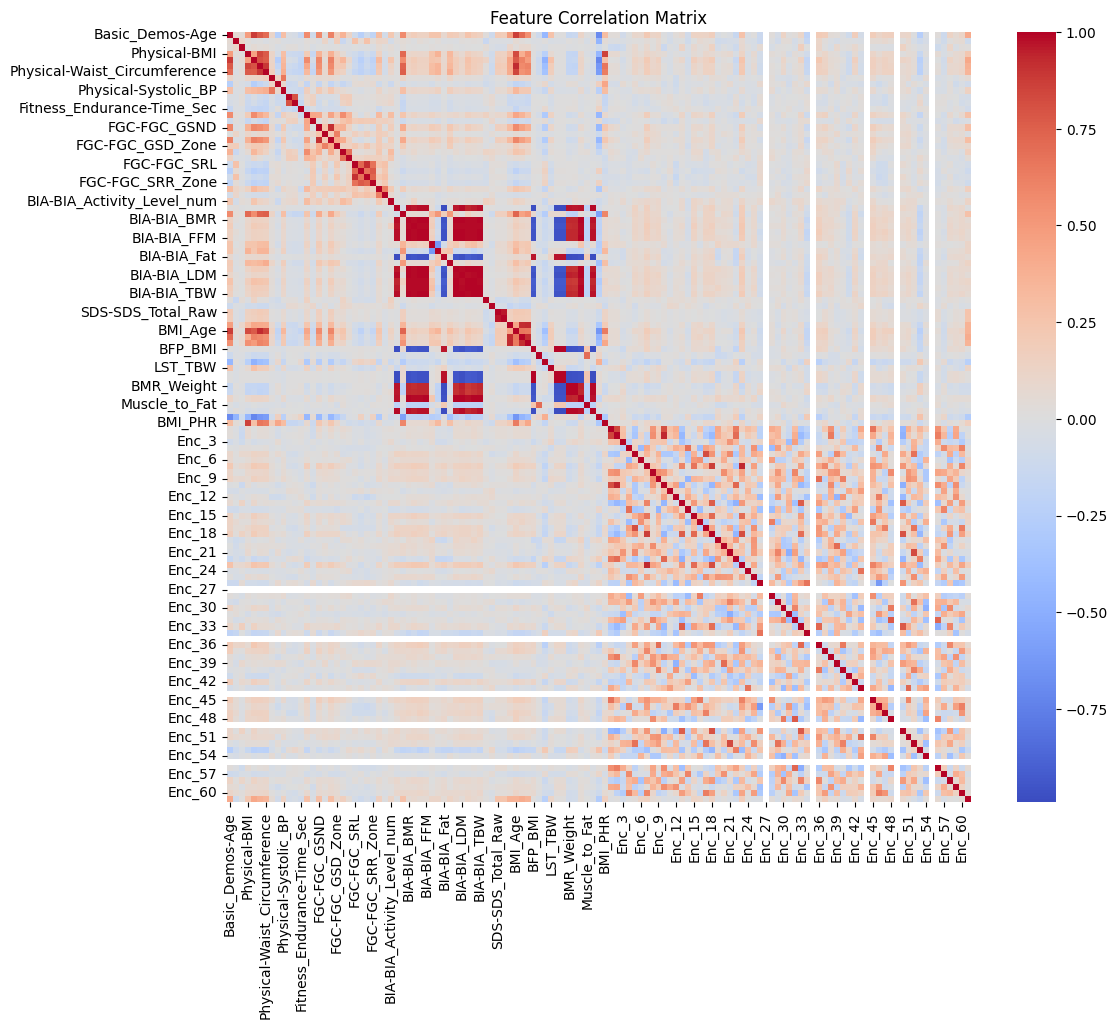

In [15]:
# Compute correlation matrix for training data
correlation_matrix = train_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()


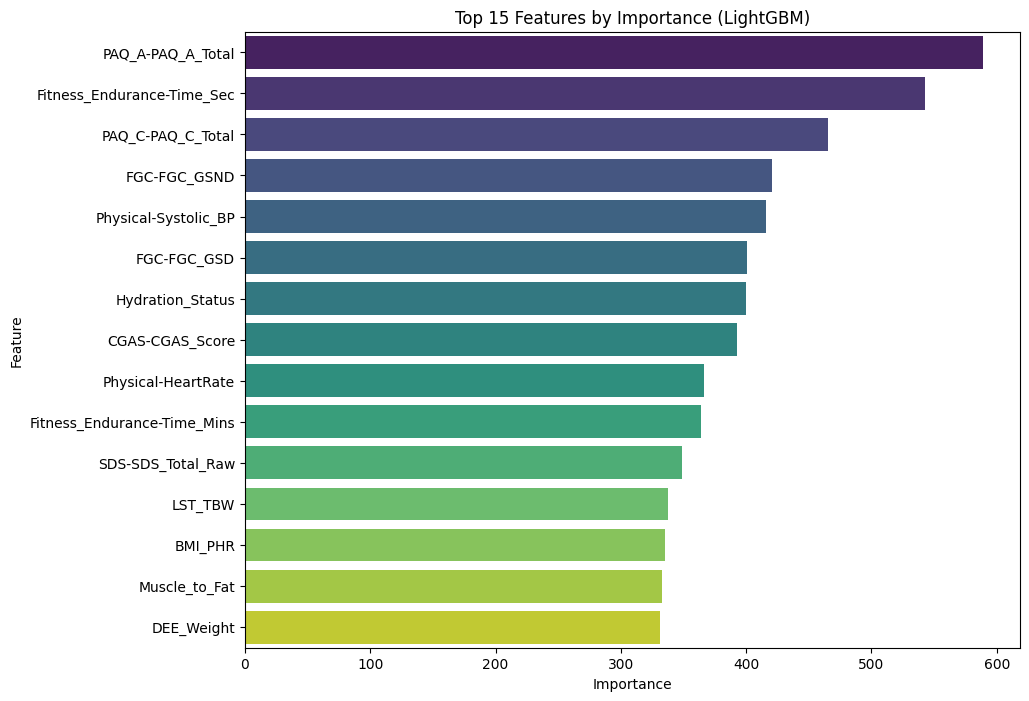

Insight: Feature importance helps us understand which features contribute the most to the model's predictions, guiding us in feature engineering


In [16]:
# Plot feature importance
lightgbm_model.fit(train_df.drop(columns=['sii']), train_df['sii'])
feature_importance = pd.DataFrame({
    'Feature': train_df.drop(columns=['sii']).columns,
    'Importance': lightgbm_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Features by Importance (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print("Insight: Feature importance helps us understand which features contribute the most to the model's predictions, guiding us in feature engineering")

In [17]:
# Load datasets
train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample_submission = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

def process_time_series_file(filename, directory):
    """
    Process a single time-series file and extract descriptive statistics.
    """
    df = pd.read_parquet(os.path.join(directory, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series_data(directory) -> pd.DataFrame:
    """
    Load time-series data from the specified directory.
    """
    ids = os.listdir(directory)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(
            executor.map(lambda fname: process_time_series_file(fname, directory), ids), 
            total=len(ids)
        ))
    
    stats, indices = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indices
    return df

# Load time-series data
train_ts = load_time_series_data("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series_data("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

# Extract time-series column names
time_series_columns = train_ts.columns.tolist()
time_series_columns.remove("id")

# Merge time-series data with main datasets
train_df = pd.merge(train_df, train_ts, how="left", on='id')
test_df = pd.merge(test_df, test_ts, how="left", on='id')

# Drop the 'id' column
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

# Feature columns
feature_columns = [
    'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
    'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
    'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
    'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
    'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
    'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
    'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
    'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
    'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
    'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
    'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
    'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
    'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
    'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
    'PreInt_EduHx-computerinternet_hoursday', 'sii'
] + time_series_columns

train_df = train_df[feature_columns]
train_df = train_df.dropna(subset=['sii'])

# Categorical columns
categorical_columns = [
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
    'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]

def preprocess_categorical_data(data, categorical_columns):
    """
    Preprocess categorical data by filling missing values and converting to category type.
    """
    for col in categorical_columns:
        data[col] = data[col].fillna('Missing')
        data[col] = data[col].astype('category')
    return data

# Preprocess categorical columns
train_df = preprocess_categorical_data(train_df, categorical_columns)
test_df = preprocess_categorical_data(test_df, categorical_columns)

def create_value_mapping(column, dataset):
    """
    Create a mapping of unique values to integers for a given column.
    """
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

# Apply mappings to categorical columns
for col in categorical_columns:
    train_mapping = create_value_mapping(col, train_df)
    test_mapping = create_value_mapping(col, test_df)
    
    train_df[col] = train_df[col].replace(train_mapping).astype(int)
    test_df[col] = test_df[col].replace(test_mapping).astype(int)

# Model parameters
lightgbm_params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0.01
}

xgboost_params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': SEED
}

catboost_params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': categorical_columns,
    'verbose': 0,
    'l2_leaf_reg': 10
}

# Model instances
lightgbm_model = LGBMRegressor(**lightgbm_params, random_state=SEED, verbose=-1, n_estimators=300)
xgboost_model = XGBRegressor(**xgboost_params)
catboost_model = CatBoostRegressor(**catboost_params)

# Combine models using Voting Regressor
voting_ensemble_model = VotingRegressor(estimators=[
    ('lightgbm', lightgbm_model),
    ('xgboost', xgboost_model),
    ('catboost', catboost_model),
])

# Train the ensemble model
ensemble_2 = TrainML(voting_ensemble_model, test_df)


Training Folds: 100%|██████████| 5/5 [00:52<00:00, 10.58s/it]

Mean Train QWK --> 0.7595
Mean Validation QWK ---> 0.3926


----> || Optimized QWK SCORE ::  0.457


In [18]:
ensemble_2

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,0


In [19]:
# Load datasets
train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample_submission = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

# Feature columns
feature_columns = [
    'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
    'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
    'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
    'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
    'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
    'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
    'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
    'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
    'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
    'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
    'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
    'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
    'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
    'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
    'PreInt_EduHx-computerinternet_hoursday', 'sii'
]

# Categorical columns
categorical_columns = [
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
    'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]

# Load time-series data
train_time_series = load_time_series_data("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_time_series = load_time_series_data("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

# Extract time-series column names
time_series_columns = train_time_series.columns.tolist()
time_series_columns.remove("id")

# Merge time-series data with main datasets
train_df = pd.merge(train_df, train_time_series, how="left", on='id')
test_df = pd.merge(test_df, test_time_series, how="left", on='id')

# Drop the 'id' column
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

# Extend feature columns with time-series features
feature_columns += time_series_columns

# Filter feature columns and drop rows with missing target
train_df = train_df[feature_columns]
train_df = train_df.dropna(subset=['sii'])

# Update categorical columns
def preprocess_categorical_columns(data, categorical_columns):
    """
    Update categorical columns by filling missing values and converting to category type.
    """
    for col in categorical_columns:
        data[col] = data[col].fillna('Missing')
        data[col] = data[col].astype('category')
    return data

train_df = preprocess_categorical_columns(train_df, categorical_columns)
test_df = preprocess_categorical_columns(test_df, categorical_columns)

# Create mappings for categorical columns
def map_categorical_columns(column, dataset):
    """
    Create a mapping for categorical values to integers for a given column.
    """
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in categorical_columns:
    train_mapping = map_categorical_columns(col, train_df)
    test_mapping = map_categorical_columns(col, test_df)
    
    train_df[col] = train_df[col].replace(train_mapping).astype(int)
    test_df[col] = test_df[col].replace(test_mapping).astype(int)

# Imputer for missing values
imputer = SimpleImputer(strategy='median')

# Voting regressor with pipelines
ensemble_model = VotingRegressor(estimators=[
    ('lightgbm', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])),
    ('xgboost', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
    ('catboost', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
    ('random_forest', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gradient_boosting', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))])),
])

# Train the ensemble model
ensemble_3 = TrainML(ensemble_model, test_df)


Training Folds: 100%|██████████| 5/5 [02:01<00:00, 24.34s/it]

Mean Train QWK --> 0.9175
Mean Validation QWK ---> 0.3803


----> || Optimized QWK SCORE ::  0.450


In [20]:
ensemble_3

,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,0


In [21]:
# Rename submissions for clarity
submission_1 = ensemble_1
submission_2 = ensemble_2
submission_3 = ensemble_3

# Sort submissions by 'id' and reset index
submission_1 = submission_1.sort_values(by='id').reset_index(drop=True)
submission_2 = submission_2.sort_values(by='id').reset_index(drop=True)
submission_3 = submission_3.sort_values(by='id').reset_index(drop=True)

# Combine the submissions into a single DataFrame
combined_submissions = pd.DataFrame({
    'id': submission_1['id'],
    'sii_1': submission_1['sii'],
    'sii_2': submission_2['sii'],
    'sii_3': submission_3['sii']
})

# Function to compute the majority vote across multiple predictions
def compute_majority_vote(row):
    """
    Compute the majority vote for a row of predictions.
    
    Args:
        row (pd.Series): Row containing predictions from multiple models.
    
    Returns:
        int: The majority-voted prediction.
    """
    return row.mode()[0]

# Apply majority voting to compute the final predictions
combined_submissions['final_sii'] = combined_submissions[['sii_1', 'sii_2', 'sii_3']].apply(compute_majority_vote, axis=1)

# Prepare the final submission file
final_submission = combined_submissions[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})

# Save to CSV
final_submission.to_csv('submission.csv', index=False)

print("Majority voting completed and saved to 'submission.csv'")


Majority voting completed and saved to 'submission.csv'


In [22]:
final_submission

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,0
